In [3]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

from utils import *
from train import *
from conv import *

### Loading Fashion MNIST data

In [4]:
BATCH_SIZE=64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [7]:
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002A220F71520>, <torch.utils.data.dataloader.DataLoader object at 0x000002A220F715B0>)
Length of train dataloader: 938 batches of 64
Length of test dataloader: 157 batches of 64


In [183]:
# show_images(train_dataset, class_names, 4, 4)
# show_images(test_dataset, class_names, 4, 4)

In [184]:
# from torch.utils.data import default_collate

In [8]:
cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 10, act=False),
    nn.Flatten()
)

In [9]:
from torch.optim.lr_scheduler import ExponentialLR

lr = 0.4

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn.parameters(), lr=lr)
schedular = ExponentialLR(optimizer, gamma=1.3)

In [188]:
# train_loss, train_acc, test_loss, test_acc 

In [10]:
def deconv(ic, oc, ks=3, act=True):
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(ic, oc, kernel_size=ks, stride=1, padding=ks//2)
    ]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [11]:
def eval(model, loss_fn, test_dataloader, epoch=0):
    test_loss, test_count = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, _ in test_dataloader:
            X = X.to(device)
            test_loss += loss_fn(model(X), X)
    
    test_count = len(test_dataloader)*(epoch+1)
    
    print(f"| Epoch: {epoch} | Loss: {test_loss / test_count} |")

In [12]:
ae = nn.Sequential(
    nn.ZeroPad2d(2),            #32x32
    conv(1, 2),                 #16x16
    conv(2, 4),                 #8x8
    conv(4, 8),                 #4x4
    deconv(8, 4),               #8x8
    deconv(4, 2),               #16x16
    deconv(2, 1, act=False),    #32x32
    nn.ZeroPad2d(-2),           #28x28
    nn.Sigmoid()
).to(device)

| Epoch: 0 | Loss: 0.1538122594356537 |


  0%|          | 0/5 [00:00<?, ?it/s]

lr: 0.4


d:\Machine Learning\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 20%|██        | 1/5 [00:06<00:27,  6.90s/it]

| Epoch: 0 | Loss: 0.09491373598575592 |
lr: 0.4
lr: 0.4


 40%|████      | 2/5 [00:13<00:20,  6.92s/it]

| Epoch: 1 | Loss: 0.04604240134358406 |
lr: 0.4
lr: 0.4


 60%|██████    | 3/5 [00:20<00:13,  6.97s/it]

| Epoch: 2 | Loss: 0.02748321183025837 |
lr: 0.4
lr: 0.4


 80%|████████  | 4/5 [00:27<00:06,  6.94s/it]

| Epoch: 3 | Loss: 0.0219486802816391 |
lr: 0.4
lr: 0.4


100%|██████████| 5/5 [00:34<00:00,  6.94s/it]

| Epoch: 4 | Loss: 0.018008427694439888 |
lr: 0.4


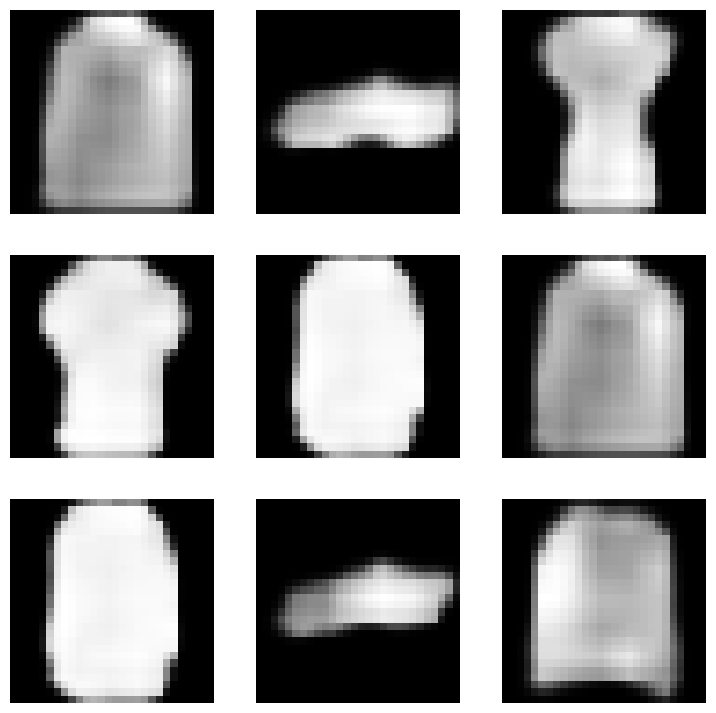

In [193]:
import torch.nn.functional as F
eval(ae, F.mse_loss, test_dataloader)
optimizer = torch.optim.SGD(params=ae.parameters(), lr=0.1)
fit(5, ae, train_dataloader, test_dataloader, F.l1_loss, optimizer, schedular, device)
X, y = next(iter(train_dataloader))
p = ae(X.to(device))
show_images(p.data.cpu())

In [194]:
# from torcheval.metrics import MulticlassAccuracy, Mean
# metric = MulticlassAccuracy()

In [195]:
def get_model():
    return nn.Sequential(
        conv(1, 8),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        nn.Flatten()
    ).to(device)